<a href="https://colab.research.google.com/github/NilakshanRaveendran/bilingual-voice-translation-research/blob/main/notebooks/English_ASR_Transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai-whisper jiwer pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 49.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 104.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803980 sha256=a1809c5fa4394e4cd82a6d3ee124dc45c8deca0a45da41b432b8a389df293cea
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

SEG_DIR = "/content/drive/MyDrive/bilingual_voice_translation/data/segments"
TSV_PATH = "/content/drive/MyDrive/bilingual_voice_translation/metadata/train_filtered_100.tsv"
OUT_DIR = "/content/drive/MyDrive/bilingual_voice_translation/results"
os.makedirs(OUT_DIR, exist_ok=True)

print("SEG_DIR:", SEG_DIR)
print("TSV_PATH:", TSV_PATH)
print("OUT_DIR:", OUT_DIR)

SEG_DIR: /content/drive/MyDrive/bilingual_voice_translation/data/segments
TSV_PATH: /content/drive/MyDrive/bilingual_voice_translation/metadata/train_filtered_100.tsv
OUT_DIR: /content/drive/MyDrive/bilingual_voice_translation/results


In [4]:
import pandas as pd

df_ref = pd.read_csv(TSV_PATH, sep="\t", header=None, names=["clip", "reference"])
print("Reference rows:", len(df_ref))
df_ref.head()

Reference rows: 100


,clip,reference
0,common_voice_es_18306544.mp3,but are their people available
1,common_voice_es_18306545.mp3,the priority is to ensure the safety of the ci...
2,common_voice_es_18306546.mp3,hey brunette
3,common_voice_es_18306547.mp3,it's obvious that you don't care anymore but
4,common_voice_es_18306548.mp3,there juvenile intruders i repeat myself recov...


In [5]:
ref_map = dict(zip(df_ref["clip"], df_ref["reference"]))
print("Example ref_map item:", next(iter(ref_map.items())))

Example ref_map item: ('common_voice_es_18306544.mp3', 'but are their people available')


In [6]:
import whisper
model = whisper.load_model("small")
print("Whisper model loaded ✅")

100%|████████████████████████████████████████| 461M/461M [00:01<00:00, 371MiB/s]


Whisper model loaded ✅


In [7]:
import re

segment_files = sorted([f for f in os.listdir(SEG_DIR) if f.endswith(".wav")])
print("Total segment files:", len(segment_files))
print("Sample:", segment_files[:5])

def segment_to_clip(seg_filename: str) -> str:
    # removes "_seg_XX.wav" and keeps ".mp3"
    # example: common_voice_es_18306544.mp3_seg_0.wav -> common_voice_es_18306544.mp3
    return re.sub(r"_seg_\d+\.wav$", "", seg_filename)

# Quick test
print("Mapping test:", segment_files[0], "->", segment_to_clip(segment_files[0]))

Total segment files: 103
Sample: ['common_voice_es_18306544.mp3_seg_0.wav', 'common_voice_es_18306545.mp3_seg_0.wav', 'common_voice_es_18306546.mp3_seg_0.wav', 'common_voice_es_18306547.mp3_seg_0.wav', 'common_voice_es_18306548.mp3_seg_0.wav']
Mapping test: common_voice_es_18306544.mp3_seg_0.wav -> common_voice_es_18306544.mp3


In [8]:
rows = []
missing_refs = 0

for seg in segment_files:
    seg_path = os.path.join(SEG_DIR, seg)
    clip_name = segment_to_clip(seg)  # e.g. common_voice_es_18306544.mp3

    # get reference text (ground truth) for that clip
    ref_text = ref_map.get(clip_name, None)
    if ref_text is None:
        missing_refs += 1

    # ASR
    result = model.transcribe(seg_path)  # language auto-detect
    hyp_text = result["text"]

    rows.append({
        "segment_file": seg,
        "clip": clip_name,
        "language_detected": result["language"],
        "asr_text": hyp_text,
        "reference_text": ref_text
    })

df_asr = pd.DataFrame(rows)
print("Done transcribing ✅")
print("Segments without reference match:", missing_refs)
df_asr.head()

Done transcribing ✅
Segments without reference match: 0


,segment_file,clip,language_detected,asr_text,reference_text
0,common_voice_es_18306544.mp3_seg_0.wav,common_voice_es_18306544.mp3,en,But are there people available?,but are their people available
1,common_voice_es_18306545.mp3_seg_0.wav,common_voice_es_18306545.mp3,en,The priority is to ensure the safety of the c...,the priority is to ensure the safety of the ci...
2,common_voice_es_18306546.mp3_seg_0.wav,common_voice_es_18306546.mp3,en,"Hey, Brunette!",hey brunette
3,common_voice_es_18306547.mp3_seg_0.wav,common_voice_es_18306547.mp3,en,"It's obvious that you don't care anymore, but...",it's obvious that you don't care anymore but
4,common_voice_es_18306548.mp3_seg_0.wav,common_voice_es_18306548.mp3,en,"There, juvenile intruders, I repeat myself.",there juvenile intruders i repeat myself recov...


In [9]:
df_asr.to_csv(f"{OUT_DIR}/asr_segments_with_refs.csv", index=False)
print("Saved:", f"{OUT_DIR}/asr_segments_with_refs.csv")

Saved: /content/drive/MyDrive/bilingual_voice_translation/results/asr_segments_with_refs.csv


In [10]:
from jiwer import wer
import re

def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = s.lower()
    # Keep letters (including accented Spanish), numbers, and spaces
    s = re.sub(r"[^0-9a-záéíóúüñ\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

eval_df = df_asr[df_asr["reference_text"].notna()].copy()

eval_df["wer"] = eval_df.apply(
    lambda x: wer(
        normalize_text(x["reference_text"]),
        normalize_text(x["asr_text"])
    ),
    axis=1
)

avg_wer = eval_df["wer"].mean() if len(eval_df) > 0 else None
print("Evaluated segments:", len(eval_df))
print("Average WER:", avg_wer)

eval_df[["segment_file","clip","language_detected","wer"]].head(10)

Evaluated segments: 103
Average WER: 0.07886458201992183


,segment_file,clip,language_detected,wer
0,common_voice_es_18306544.mp3_seg_0.wav,common_voice_es_18306544.mp3,en,0.2
1,common_voice_es_18306545.mp3_seg_0.wav,common_voice_es_18306545.mp3,en,0.0
2,common_voice_es_18306546.mp3_seg_0.wav,common_voice_es_18306546.mp3,en,0.0
3,common_voice_es_18306547.mp3_seg_0.wav,common_voice_es_18306547.mp3,en,0.0
4,common_voice_es_18306548.mp3_seg_0.wav,common_voice_es_18306548.mp3,en,0.4
5,common_voice_es_18306548.mp3_seg_1.wav,common_voice_es_18306548.mp3,en,0.6
6,common_voice_es_18306565.mp3_seg_0.wav,common_voice_es_18306565.mp3,en,0.0
7,common_voice_es_18306566.mp3_seg_0.wav,common_voice_es_18306566.mp3,en,0.0
8,common_voice_es_18306567.mp3_seg_0.wav,common_voice_es_18306567.mp3,en,0.0
9,common_voice_es_18306568.mp3_seg_0.wav,common_voice_es_18306568.mp3,en,0.0


In [11]:
eval_df.to_csv(f"{OUT_DIR}/asr_wer_results.csv", index=False)
print("Saved:", f"{OUT_DIR}/asr_wer_results.csv")

Saved: /content/drive/MyDrive/bilingual_voice_translation/results/asr_wer_results.csv


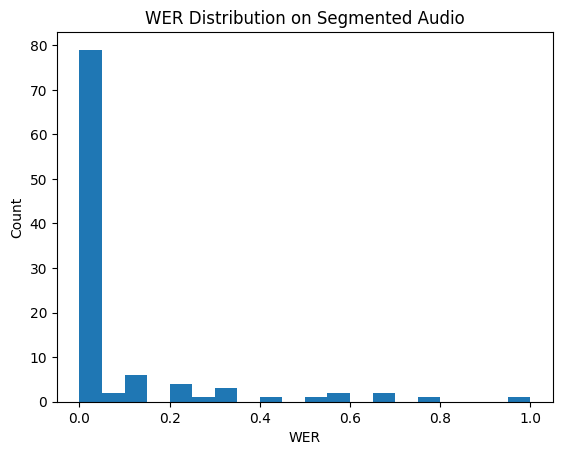

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(eval_df["wer"], bins=20)
plt.xlabel("WER")
plt.ylabel("Count")
plt.title("WER Distribution on Segmented Audio")
plt.show()